In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from keras.src.callbacks import EarlyStopping
import random
import numpy as np
import tensorflow as tf
from keras.api.layers import Dense, Dropout
from keras.api.models import Sequential
from keras.api.regularizers import l1, l2
from keras.api.optimizers import Adam

In [2]:
def set_seeds(seed = 100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
def cw(df):
    c0, c1 = np.bincount(df["dir"])
    w0 = (1/c0) * (len(df)) / 2
    w1 = (1/c1) * (len(df)) / 2
    return {0:w0, 1:w1}

def create_model(hl = 2, hu = 100, dropout = False, rate = 0.3, regularize = False,
                 reg = l1(0.0005), optimizer = Adam(learning_rate = 0.0001), input_dim = None):
    if not regularize:
        reg = None
    model = Sequential()
    model.add(Dense(hu, input_dim = input_dim, activity_regularizer = reg ,activation = "relu", kernel_regularizer=l2(0.001), ))
    if dropout: 
        model.add(Dropout(rate, seed = 100))
    for layer in range(hl):
        model.add(Dense(hu, activation = "relu", activity_regularizer = reg, kernel_regularizer=l2(0.001),))
        if dropout:
            model.add(Dropout(rate, seed = 100))
    model.add(Dense(1, activation = "sigmoid"))

    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    return model

In [3]:
symbol = "EURUSD=X"
#start = "2022-08-27"
start = "2004-01-01"
end = "2024-08-20"
interval = '1d'
ptc = 0.000059

In [6]:
df = yf.download(symbol, start, end, interval=interval)
#df.rename(columns={"Close": "price"}, inplace=True)
df.drop(columns=['Adj Close', 'Volume'], inplace=True)
#df.index = df.index.tz_convert('utc')
df['returns'] = np.log(df['Close'].div(df['Close'].shift(1)))
df['day_of_week'] = df.index.dayofweek
df['dir'] = np.where(df['returns'] > 0, 1,0)
df.dropna(inplace=True)
features = ["dir", 'Open', 'High', 'Low', 'Close', 'returns']

[*********************100%%**********************]  1 of 1 completed


In [8]:
resultsDf = pd.DataFrame(columns=['lag', 'result', 'cagr', 'num_trades'])

for lag in range(1,48):
    copy = df.copy()
    cols = []
    for f in features:
        for lag in range(1, lag + 1):
            col = "{}_lag_{}".format(f, lag)
            copy[col] = copy[f].shift(lag)
            cols.append(col)
    copy.dropna(inplace=True)
    cols.append('day_of_week')
    split = int(len(copy)* 0.8)
    train = copy.iloc[:split].copy()
    test = copy.iloc[split:].copy()
    mu, std = train.mean(), train.std()
    train_standardized = (train-mu) / std
    
    optimizer = Adam(learning_rate = 0.0001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    set_seeds(100)

    model = create_model(hl=2, hu=50, dropout= True, input_dim=len(cols), optimizer=optimizer)
    model.fit(x=train_standardized[cols], y=train['dir'], epochs=50, verbose=True,
              validation_split=0.2, shuffle=False, class_weight=cw(train), callbacks=[early_stopping] )
    
    model.evaluate(train_standardized[cols], train['dir'])
    predict = model.predict(train_standardized[cols])
    
    test_standardized = (test-mu) / std
    model.evaluate(test_standardized[cols], test['dir'])
    test['probability'] = model.predict(test_standardized[cols])
    threshold = 0.53
    test['position'] = np.where(test.probability < (1-threshold), -1, np.nan)
    test['position'] = np.where(test.probability > threshold, 1, test.position)
    test['position'] = test.position.ffill()
    test['strategy'] = test['position'] * test['returns']
    test['creturns'] = test['returns'].cumsum().apply(np.exp)
    test['cstrategy'] = test['strategy'].cumsum().apply(np.exp)
    test['trades'] = test.position.diff().abs()
    test['strategy_net'] = test.strategy - test.trades * ptc
    test['cstrategy_net'] = test['strategy_net'].cumsum().apply(np.exp)
    
    
    
    
    resultDict =  { 
        'lag': lag, 'result': test['cstrategy'].iloc[-1], 'cagr': test[['strategy_net']].mean() * 252, 'num_trades': test['trades'].sum()
    }
    resultsDf.loc[len(resultsDf)] = resultDict

    

Epoch 1/50


C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5138 - loss: 0.8120 - val_accuracy: 0.4836 - val_loss: 0.8043
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5224 - loss: 0.8055 - val_accuracy: 0.4953 - val_loss: 0.8003
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5021 - loss: 0.8017 - val_accuracy: 0.4988 - val_loss: 0.7981
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5244 - loss: 0.7980 - val_accuracy: 0.5012 - val_loss: 0.7958
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5095 - loss: 0.7982 - val_accuracy: 0.4895 - val_loss: 0.7938
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5298 - loss: 0.7913 - val_accuracy: 0.4930 - val_loss: 0.7919
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5004 - loss: 0.7942 - val_accuracy: 0.4895 - val_loss: 0.7902
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5045 - loss: 0.7906 - val_accuracy: 0.4942 - val_

C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5043 - loss: 0.8340 - val_accuracy: 0.4907 - val_loss: 0.8178
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5079 - loss: 0.8268 - val_accuracy: 0.4930 - val_loss: 0.8124
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4962 - loss: 0.8176 - val_accuracy: 0.4907 - val_loss: 0.8097
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - accuracy: 0.5009 - loss: 0.8173 - val_accuracy: 0.4942 - val_loss: 0.8072
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5177 - loss: 0.8114 - val_accuracy: 0.4918 - val_loss: 0.8051
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5051 - loss: 0.8116 - val_accuracy: 0.4953 - val_loss: 0.8035
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.5085 - loss: 0.8079 - val_accuracy: 0.4953 - val_loss: 0.8018
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.5299 - loss: 0.8001 - val_accuracy: 0.4918 

C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5095 - loss: 0.8428 - val_accuracy: 0.4895 - val_loss: 0.8256
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5002 - loss: 0.8462 - val_accuracy: 0.4930 - val_loss: 0.8183
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4955 - loss: 0.8291 - val_accuracy: 0.5035 - val_loss: 0.8149
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4866 - loss: 0.8231 - val_accuracy: 0.5047 - val_loss: 0.8127
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4990 - loss: 0.8254 - val_accuracy: 0.5047 - val_loss: 0.8109
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4956 - loss: 0.8193 - val_accuracy: 0.5058 - val_loss: 0.8093
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4902 - loss: 0.8151 - val_accuracy: 0.5117 - val_loss: 0.8077
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4915 - loss: 0.8126 - val_accuracy: 0.5082 - val_

C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4803 - loss: 0.8666 - val_accuracy: 0.4930 - val_loss: 0.8328
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4922 - loss: 0.8501 - val_accuracy: 0.4825 - val_loss: 0.8262
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5105 - loss: 0.8342 - val_accuracy: 0.4673 - val_loss: 0.8229
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4984 - loss: 0.8362 - val_accuracy: 0.4743 - val_loss: 0.8204
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5159 - loss: 0.8330 - val_accuracy: 0.4801 - val_loss: 0.8181
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5144 - loss: 0.8270 - val_accuracy: 0.4801 - val_loss: 0.8163
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5091 - loss: 0.8220 - val_accuracy: 0.4883 - val_loss: 0.8144
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5011 - loss: 0.8228 - val_accuracy: 0.4860 - val_

C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4889 - loss: 0.8608 - val_accuracy: 0.4942 - val_loss: 0.8374
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5016 - loss: 0.8493 - val_accuracy: 0.5000 - val_loss: 0.8314
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5070 - loss: 0.8459 - val_accuracy: 0.4965 - val_loss: 0.8277
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5217 - loss: 0.8354 - val_accuracy: 0.4895 - val_loss: 0.8255
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5020 - loss: 0.8351 - val_accuracy: 0.4988 - val_loss: 0.8234
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5031 - loss: 0.8297 - val_accuracy: 0.5175 - val_loss: 0.8218
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5002 - loss: 0.8315 - val_accuracy: 0.5035 - val_loss: 0.8203
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4854 - loss: 0.8295 - val_accuracy: 0.5058 - val_

C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5041 - loss: 0.8661 - val_accuracy: 0.4801 - val_loss: 0.8448
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4993 - loss: 0.8589 - val_accuracy: 0.4790 - val_loss: 0.8380
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4861 - loss: 0.8513 - val_accuracy: 0.4930 - val_loss: 0.8342
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5142 - loss: 0.8449 - val_accuracy: 0.4977 - val_loss: 0.8316
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5125 - loss: 0.8395 - val_accuracy: 0.4965 - val_loss: 0.8295
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5083 - loss: 0.8358 - val_accuracy: 0.4825 - val_loss: 0.8279
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5110 - loss: 0.8333 - val_accuracy: 0.4801 - val_loss: 0.8266
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5090 - loss: 0.8315 - val_accuracy: 0.4813 - val_

C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4771 - loss: 0.8853 - val_accuracy: 0.4860 - val_loss: 0.8480
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4853 - loss: 0.8629 - val_accuracy: 0.4836 - val_loss: 0.8413
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4993 - loss: 0.8551 - val_accuracy: 0.4848 - val_loss: 0.8383
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5056 - loss: 0.8500 - val_accuracy: 0.4743 - val_loss: 0.8361
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5134 - loss: 0.8423 - val_accuracy: 0.4650 - val_loss: 0.8334
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4922 - loss: 0.8467 - val_accuracy: 0.4790 - val_loss: 0.8312
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5023 - loss: 0.8397 - val_accuracy: 0.4708 - val_loss: 0.8297
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5104 - loss: 0.8337 - val_accuracy: 0.4743 - val_

C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4889 - loss: 0.8835 - val_accuracy: 0.4889 - val_loss: 0.8618
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4998 - loss: 0.8683 - val_accuracy: 0.4877 - val_loss: 0.8459
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5239 - loss: 0.8601 - val_accuracy: 0.4865 - val_loss: 0.8421
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5234 - loss: 0.8511 - val_accuracy: 0.4901 - val_loss: 0.8408
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5073 - loss: 0.8531 - val_accuracy: 0.4819 - val_loss: 0.8399
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4858 - loss: 0.8503 - val_accuracy: 0.4830 - val_loss: 0.8379
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4964 - loss: 0.8451 - val_accuracy: 0.4842 - val_loss: 0.8355
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4892 - loss: 0.8420 - val_accuracy: 0.4901 - val_

C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5017 - loss: 0.8903 - val_accuracy: 0.4912 - val_loss: 0.8699
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5281 - loss: 0.8701 - val_accuracy: 0.4971 - val_loss: 0.8528
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5213 - loss: 0.8550 - val_accuracy: 0.4901 - val_loss: 0.8491
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5127 - loss: 0.8592 - val_accuracy: 0.4959 - val_loss: 0.8453
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5013 - loss: 0.8574 - val_accuracy: 0.4912 - val_loss: 0.8426
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5163 - loss: 0.8462 - val_accuracy: 0.4912 - val_loss: 0.8413
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5131 - loss: 0.8425 - val_accuracy: 0.4947 - val_loss: 0.8397
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5000 - loss: 0.8469 - val_accuracy: 0.4865 - val_

C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4876 - loss: 0.9005 - val_accuracy: 0.4936 - val_loss: 0.8582
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5205 - loss: 0.8681 - val_accuracy: 0.4936 - val_loss: 0.8483
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4888 - loss: 0.8647 - val_accuracy: 0.4971 - val_loss: 0.8451
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5051 - loss: 0.8539 - val_accuracy: 0.4936 - val_loss: 0.8437
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4927 - loss: 0.8564 - val_accuracy: 0.4854 - val_loss: 0.8412
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4907 - loss: 0.8542 - val_accuracy: 0.4947 - val_loss: 0.8394
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5115 - loss: 0.8467 - val_accuracy: 0.4936 - val_loss: 0.8375
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5162 - loss: 0.8458 - val_accuracy: 0.5076 - val_

C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4830 - loss: 0.9051 - val_accuracy: 0.4854 - val_loss: 0.8662
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5024 - loss: 0.8797 - val_accuracy: 0.4842 - val_loss: 0.8561
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5056 - loss: 0.8604 - val_accuracy: 0.4830 - val_loss: 0.8533
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4982 - loss: 0.8665 - val_accuracy: 0.4830 - val_loss: 0.8505
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5230 - loss: 0.8538 - val_accuracy: 0.4842 - val_loss: 0.8484
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5280 - loss: 0.8430 - val_accuracy: 0.4807 - val_loss: 0.8462
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4903 - loss: 0.8499 - val_accuracy: 0.4713 - val_loss: 0.8439
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5010 - loss: 0.8447 - val_accuracy: 0.4877 - val_

C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4998 - loss: 0.9064 - val_accuracy: 0.5006 - val_loss: 0.8749
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4938 - loss: 0.8854 - val_accuracy: 0.5006 - val_loss: 0.8584
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5046 - loss: 0.8653 - val_accuracy: 0.5064 - val_loss: 0.8541
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5028 - loss: 0.8596 - val_accuracy: 0.5088 - val_loss: 0.8503
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5213 - loss: 0.8511 - val_accuracy: 0.5041 - val_loss: 0.8476
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5192 - loss: 0.8505 - val_accuracy: 0.5018 - val_loss: 0.8454
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5200 - loss: 0.8486 - val_accuracy: 0.4994 - val_loss: 0.8433
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5236 - loss: 0.8461 - val_accuracy: 0.5018 - val_

C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4916 - loss: 0.9053 - val_accuracy: 0.4982 - val_loss: 0.8660
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5137 - loss: 0.8787 - val_accuracy: 0.5053 - val_loss: 0.8574
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5093 - loss: 0.8640 - val_accuracy: 0.5053 - val_loss: 0.8537
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4814 - loss: 0.8695 - val_accuracy: 0.5018 - val_loss: 0.8506
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4953 - loss: 0.8558 - val_accuracy: 0.5018 - val_loss: 0.8493
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5032 - loss: 0.8582 - val_accuracy: 0.4982 - val_loss: 0.8477
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5133 - loss: 0.8516 - val_accuracy: 0.5029 - val_loss: 0.8453
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5140 - loss: 0.8519 - val_accuracy: 0.5088 - val_

C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5017 - loss: 0.9051 - val_accuracy: 0.4895 - val_loss: 0.8634
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5242 - loss: 0.8780 - val_accuracy: 0.5012 - val_loss: 0.8562
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5118 - loss: 0.8683 - val_accuracy: 0.4977 - val_loss: 0.8535
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5132 - loss: 0.8717 - val_accuracy: 0.5047 - val_loss: 0.8515
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5117 - loss: 0.8599 - val_accuracy: 0.5117 - val_loss: 0.8496
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5080 - loss: 0.8601 - val_accuracy: 0.5152 - val_loss: 0.8473
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4848 - loss: 0.8562 - val_accuracy: 0.5012 - val_loss: 0.8454
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5065 - loss: 0.8532 - val_accuracy: 0.4953 - val_

C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5052 - loss: 0.9006 - val_accuracy: 0.4965 - val_loss: 0.8640
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4997 - loss: 0.8855 - val_accuracy: 0.4953 - val_loss: 0.8584
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4953 - loss: 0.8817 - val_accuracy: 0.4941 - val_loss: 0.8558
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5072 - loss: 0.8695 - val_accuracy: 0.4895 - val_loss: 0.8533
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5206 - loss: 0.8598 - val_accuracy: 0.4965 - val_loss: 0.8516
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4999 - loss: 0.8631 - val_accuracy: 0.4930 - val_loss: 0.8504
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4880 - loss: 0.8581 - val_accuracy: 0.4813 - val_loss: 0.8492
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5147 - loss: 0.8516 - val_accuracy: 0.4801 - val_

C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5073 - loss: 0.9079 - val_accuracy: 0.4859 - val_loss: 0.8710
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5023 - loss: 0.8892 - val_accuracy: 0.4778 - val_loss: 0.8657
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4956 - loss: 0.8800 - val_accuracy: 0.4731 - val_loss: 0.8618
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5011 - loss: 0.8738 - val_accuracy: 0.4859 - val_loss: 0.8598
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4675 - loss: 0.8741 - val_accuracy: 0.4649 - val_loss: 0.8566
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5110 - loss: 0.8605 - val_accuracy: 0.4719 - val_loss: 0.8551
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5014 - loss: 0.8642 - val_accuracy: 0.4813 - val_loss: 0.8530
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5083 - loss: 0.8545 - val_accuracy: 0.4778 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4972 - loss: 0.9084 - val_accuracy: 0.4918 - val_loss: 0.8750
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5112 - loss: 0.8957 - val_accuracy: 0.4918 - val_loss: 0.8679
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4928 - loss: 0.8790 - val_accuracy: 0.4824 - val_loss: 0.8615
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5024 - loss: 0.8805 - val_accuracy: 0.4906 - val_loss: 0.8584
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5036 - loss: 0.8760 - val_accuracy: 0.4883 - val_loss: 0.8544
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5103 - loss: 0.8626 - val_accuracy: 0.4836 - val_loss: 0.8536
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5022 - loss: 0.8631 - val_accuracy: 0.4895 - val_loss: 0.8529
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5006 - loss: 0.8613 - val_accuracy: 0.4859 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4985 - loss: 0.9109 - val_accuracy: 0.4918 - val_loss: 0.8755
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5050 - loss: 0.8891 - val_accuracy: 0.4941 - val_loss: 0.8690
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5262 - loss: 0.8717 - val_accuracy: 0.4918 - val_loss: 0.8645
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4975 - loss: 0.8705 - val_accuracy: 0.4895 - val_loss: 0.8618
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5016 - loss: 0.8705 - val_accuracy: 0.4836 - val_loss: 0.8595
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5170 - loss: 0.8630 - val_accuracy: 0.4789 - val_loss: 0.8573
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5292 - loss: 0.8568 - val_accuracy: 0.4789 - val_loss: 0.8551
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5143 - loss: 0.8548 - val_accuracy: 0.4824 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5089 - loss: 0.9033 - val_accuracy: 0.4813 - val_loss: 0.8840
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4961 - loss: 0.9033 - val_accuracy: 0.4824 - val_loss: 0.8778
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5130 - loss: 0.8773 - val_accuracy: 0.4883 - val_loss: 0.8693
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5008 - loss: 0.8735 - val_accuracy: 0.4848 - val_loss: 0.8673
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4908 - loss: 0.8709 - val_accuracy: 0.4836 - val_loss: 0.8621
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5032 - loss: 0.8675 - val_accuracy: 0.4766 - val_loss: 0.8596
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5076 - loss: 0.8666 - val_accuracy: 0.4859 - val_loss: 0.8571
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4942 - loss: 0.8616 - val_accuracy: 0.4836 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5161 - loss: 0.9151 - val_accuracy: 0.5100 - val_loss: 0.8802
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5024 - loss: 0.8976 - val_accuracy: 0.5053 - val_loss: 0.8689
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4838 - loss: 0.8876 - val_accuracy: 0.4994 - val_loss: 0.8689
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4956 - loss: 0.8815 - val_accuracy: 0.4971 - val_loss: 0.8677
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4982 - loss: 0.8761 - val_accuracy: 0.5041 - val_loss: 0.8628
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5007 - loss: 0.8700 - val_accuracy: 0.4994 - val_loss: 0.8577
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4832 - loss: 0.8664 - val_accuracy: 0.4971 - val_loss: 0.8546
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5243 - loss: 0.8600 - val_accuracy: 0.4947 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4802 - loss: 0.9366 - val_accuracy: 0.4994 - val_loss: 0.8783
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4904 - loss: 0.8940 - val_accuracy: 0.5053 - val_loss: 0.8700
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5186 - loss: 0.8746 - val_accuracy: 0.5006 - val_loss: 0.8650
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5111 - loss: 0.8751 - val_accuracy: 0.5088 - val_loss: 0.8615
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5178 - loss: 0.8702 - val_accuracy: 0.5100 - val_loss: 0.8591
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5061 - loss: 0.8692 - val_accuracy: 0.4982 - val_loss: 0.8574
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4847 - loss: 0.8701 - val_accuracy: 0.4959 - val_loss: 0.8560
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5334 - loss: 0.8577 - val_accuracy: 0.5029 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4965 - loss: 0.9239 - val_accuracy: 0.4936 - val_loss: 0.8781
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5160 - loss: 0.8920 - val_accuracy: 0.4924 - val_loss: 0.8697
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5083 - loss: 0.8789 - val_accuracy: 0.5006 - val_loss: 0.8682
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5183 - loss: 0.8763 - val_accuracy: 0.4889 - val_loss: 0.8656
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5012 - loss: 0.8665 - val_accuracy: 0.4924 - val_loss: 0.8611
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5216 - loss: 0.8643 - val_accuracy: 0.5029 - val_loss: 0.8593
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5120 - loss: 0.8709 - val_accuracy: 0.4982 - val_loss: 0.8566
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5031 - loss: 0.8632 - val_accuracy: 0.

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5042 - loss: 0.9353 - val_accuracy: 0.4959 - val_loss: 0.8785
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5172 - loss: 0.9005 - val_accuracy: 0.4853 - val_loss: 0.8706
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5076 - loss: 0.8830 - val_accuracy: 0.4912 - val_loss: 0.8669
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5161 - loss: 0.8766 - val_accuracy: 0.4947 - val_loss: 0.8639
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5104 - loss: 0.8695 - val_accuracy: 0.4959 - val_loss: 0.8613
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5122 - loss: 0.8666 - val_accuracy: 0.4889 - val_loss: 0.8594
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5257 - loss: 0.8634 - val_accuracy: 0.4853 - val_loss: 0.8580
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5166 - loss: 0.8615 - val_accuracy: 0.4853 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4943 - loss: 0.9350 - val_accuracy: 0.5041 - val_loss: 0.8776
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5180 - loss: 0.8970 - val_accuracy: 0.4971 - val_loss: 0.8725
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5256 - loss: 0.8830 - val_accuracy: 0.4865 - val_loss: 0.8694
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5051 - loss: 0.8783 - val_accuracy: 0.4947 - val_loss: 0.8665
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5049 - loss: 0.8741 - val_accuracy: 0.4912 - val_loss: 0.8645
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4973 - loss: 0.8750 - val_accuracy: 0.4971 - val_loss: 0.8626
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5229 - loss: 0.8562 - val_accuracy: 0.4865 - val_loss: 0.8607
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5285 - loss: 0.8586 - val_accuracy: 0.4842 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4913 - loss: 0.9319 - val_accuracy: 0.5053 - val_loss: 0.8697
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4984 - loss: 0.9029 - val_accuracy: 0.5088 - val_loss: 0.8655
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4848 - loss: 0.8882 - val_accuracy: 0.5135 - val_loss: 0.8643
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5193 - loss: 0.8708 - val_accuracy: 0.5018 - val_loss: 0.8619
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5328 - loss: 0.8720 - val_accuracy: 0.4994 - val_loss: 0.8595
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5255 - loss: 0.8625 - val_accuracy: 0.5029 - val_loss: 0.8584
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4979 - loss: 0.8712 - val_accuracy: 0.4865 - val_loss: 0.8573
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5364 - loss: 0.8588 - val_accuracy: 0.4877 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5122 - loss: 0.9276 - val_accuracy: 0.4894 - val_loss: 0.8795
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5245 - loss: 0.8951 - val_accuracy: 0.5035 - val_loss: 0.8708
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4960 - loss: 0.8875 - val_accuracy: 0.4977 - val_loss: 0.8683
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5197 - loss: 0.8787 - val_accuracy: 0.4824 - val_loss: 0.8668
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4942 - loss: 0.8782 - val_accuracy: 0.4930 - val_loss: 0.8631
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5058 - loss: 0.8679 - val_accuracy: 0.4847 - val_loss: 0.8605
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5090 - loss: 0.8698 - val_accuracy: 0.4977 - val_loss: 0.8589
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5099 - loss: 0.8649 - val_accuracy: 0.4988 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5039 - loss: 0.9244 - val_accuracy: 0.4906 - val_loss: 0.8784
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5142 - loss: 0.8972 - val_accuracy: 0.4965 - val_loss: 0.8735
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5090 - loss: 0.8936 - val_accuracy: 0.5106 - val_loss: 0.8701
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5239 - loss: 0.8760 - val_accuracy: 0.5023 - val_loss: 0.8670
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5235 - loss: 0.8734 - val_accuracy: 0.4824 - val_loss: 0.8658
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5145 - loss: 0.8727 - val_accuracy: 0.4836 - val_loss: 0.8642
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5089 - loss: 0.8685 - val_accuracy: 0.4894 - val_loss: 0.8617
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5115 - loss: 0.8661 - val_accuracy: 0.4871 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5005 - loss: 0.9409 - val_accuracy: 0.5094 - val_loss: 0.8733
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4927 - loss: 0.9087 - val_accuracy: 0.4941 - val_loss: 0.8695
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5053 - loss: 0.8892 - val_accuracy: 0.4871 - val_loss: 0.8680
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5176 - loss: 0.8788 - val_accuracy: 0.4824 - val_loss: 0.8659
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4922 - loss: 0.8852 - val_accuracy: 0.4871 - val_loss: 0.8648
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5067 - loss: 0.8741 - val_accuracy: 0.4859 - val_loss: 0.8638
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4955 - loss: 0.8737 - val_accuracy: 0.4894 - val_loss: 0.8615
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5007 - loss: 0.8682 - val_accuracy: 0.4894 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4996 - loss: 0.9379 - val_accuracy: 0.5129 - val_loss: 0.8728
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5042 - loss: 0.9027 - val_accuracy: 0.4977 - val_loss: 0.8689
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5175 - loss: 0.8954 - val_accuracy: 0.5082 - val_loss: 0.8691
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4923 - loss: 0.8875 - val_accuracy: 0.4941 - val_loss: 0.8668
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5103 - loss: 0.8761 - val_accuracy: 0.4965 - val_loss: 0.8649
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5215 - loss: 0.8713 - val_accuracy: 0.4941 - val_loss: 0.8641
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5126 - loss: 0.8697 - val_accuracy: 0.4824 - val_loss: 0.8619
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5332 - loss: 0.8630 - val_accuracy: 0.4894 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4982 - loss: 0.9307 - val_accuracy: 0.4777 - val_loss: 0.8817
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5040 - loss: 0.9042 - val_accuracy: 0.4953 - val_loss: 0.8758
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5037 - loss: 0.8905 - val_accuracy: 0.4894 - val_loss: 0.8732
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4995 - loss: 0.8925 - val_accuracy: 0.4918 - val_loss: 0.8693
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5035 - loss: 0.8814 - val_accuracy: 0.4730 - val_loss: 0.8673
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5147 - loss: 0.8697 - val_accuracy: 0.4742 - val_loss: 0.8651
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5077 - loss: 0.8704 - val_accuracy: 0.4824 - val_loss: 0.8646
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5252 - loss: 0.8640 - val_accuracy: 0.4847 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4945 - loss: 0.9414 - val_accuracy: 0.5082 - val_loss: 0.8782
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4942 - loss: 0.9158 - val_accuracy: 0.4941 - val_loss: 0.8738
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5183 - loss: 0.8872 - val_accuracy: 0.5070 - val_loss: 0.8711
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5048 - loss: 0.8886 - val_accuracy: 0.4847 - val_loss: 0.8686
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5076 - loss: 0.8787 - val_accuracy: 0.5000 - val_loss: 0.8662
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5088 - loss: 0.8719 - val_accuracy: 0.4824 - val_loss: 0.8635
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4975 - loss: 0.8790 - val_accuracy: 0.5012 - val_loss: 0.8614
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5175 - loss: 0.8714 - val_accuracy: 0.4906 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5016 - loss: 0.9366 - val_accuracy: 0.5258 - val_loss: 0.8696
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5183 - loss: 0.8980 - val_accuracy: 0.5153 - val_loss: 0.8672
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5199 - loss: 0.8929 - val_accuracy: 0.5270 - val_loss: 0.8665
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5074 - loss: 0.8839 - val_accuracy: 0.5129 - val_loss: 0.8657
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5074 - loss: 0.8820 - val_accuracy: 0.5129 - val_loss: 0.8643
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5075 - loss: 0.8739 - val_accuracy: 0.4859 - val_loss: 0.8635
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5174 - loss: 0.8698 - val_accuracy: 0.5000 - val_loss: 0.8620
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5257 - loss: 0.8640 - val_accuracy: 0.4941 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5171 - loss: 0.9340 - val_accuracy: 0.5029 - val_loss: 0.8779
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5066 - loss: 0.9059 - val_accuracy: 0.4924 - val_loss: 0.8746
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5240 - loss: 0.8863 - val_accuracy: 0.5029 - val_loss: 0.8713
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5257 - loss: 0.8832 - val_accuracy: 0.4959 - val_loss: 0.8697
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5123 - loss: 0.8779 - val_accuracy: 0.4912 - val_loss: 0.8686
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5181 - loss: 0.8743 - val_accuracy: 0.4900 - val_loss: 0.8668
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5037 - loss: 0.8776 - val_accuracy: 0.4783 - val_loss: 0.8659
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5086 - loss: 0.8764 - val_accuracy: 0.4806 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4904 - loss: 0.9427 - val_accuracy: 0.5076 - val_loss: 0.8702
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4959 - loss: 0.9076 - val_accuracy: 0.5182 - val_loss: 0.8681
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4868 - loss: 0.9001 - val_accuracy: 0.5076 - val_loss: 0.8686
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5066 - loss: 0.8851 - val_accuracy: 0.4947 - val_loss: 0.8671
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5115 - loss: 0.8807 - val_accuracy: 0.4994 - val_loss: 0.8660
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5067 - loss: 0.8784 - val_accuracy: 0.4994 - val_loss: 0.8646
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5038 - loss: 0.8758 - val_accuracy: 0.4971 - val_loss: 0.8630
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5073 - loss: 0.8729 - val_accuracy: 0.4935 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5057 - loss: 0.9347 - val_accuracy: 0.5229 - val_loss: 0.8732
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5347 - loss: 0.8908 - val_accuracy: 0.5311 - val_loss: 0.8699
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5135 - loss: 0.8861 - val_accuracy: 0.5264 - val_loss: 0.8673
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5141 - loss: 0.8862 - val_accuracy: 0.5358 - val_loss: 0.8671
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5007 - loss: 0.8800 - val_accuracy: 0.5241 - val_loss: 0.8655
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5292 - loss: 0.8682 - val_accuracy: 0.5182 - val_loss: 0.8631
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5091 - loss: 0.8776 - val_accuracy: 0.5170 - val_loss: 0.8618
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4954 - loss: 0.8749 - val_accuracy: 0.5170 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5172 - loss: 0.9303 - val_accuracy: 0.4959 - val_loss: 0.8802
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5155 - loss: 0.9001 - val_accuracy: 0.4865 - val_loss: 0.8747
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5108 - loss: 0.8983 - val_accuracy: 0.4994 - val_loss: 0.8714
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4842 - loss: 0.8887 - val_accuracy: 0.4982 - val_loss: 0.8689
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5152 - loss: 0.8781 - val_accuracy: 0.5041 - val_loss: 0.8674
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5040 - loss: 0.8824 - val_accuracy: 0.4994 - val_loss: 0.8650
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5297 - loss: 0.8641 - val_accuracy: 0.5264 - val_loss: 0.8620
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5073 - loss: 0.8730 - val_accuracy: 0.5217 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4903 - loss: 0.9450 - val_accuracy: 0.4959 - val_loss: 0.8777
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4863 - loss: 0.9105 - val_accuracy: 0.5088 - val_loss: 0.8749
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5129 - loss: 0.8904 - val_accuracy: 0.4959 - val_loss: 0.8743
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5099 - loss: 0.8920 - val_accuracy: 0.5100 - val_loss: 0.8704
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5004 - loss: 0.8892 - val_accuracy: 0.5029 - val_loss: 0.8674
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5069 - loss: 0.8836 - val_accuracy: 0.5006 - val_loss: 0.8670
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5204 - loss: 0.8725 - val_accuracy: 0.5029 - val_loss: 0.8653
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5106 - loss: 0.8702 - val_accuracy: 0.4912 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4925 - loss: 0.9408 - val_accuracy: 0.5041 - val_loss: 0.8767
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5001 - loss: 0.9050 - val_accuracy: 0.4994 - val_loss: 0.8739
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5075 - loss: 0.8967 - val_accuracy: 0.4877 - val_loss: 0.8716
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5148 - loss: 0.8808 - val_accuracy: 0.4783 - val_loss: 0.8700
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5031 - loss: 0.8823 - val_accuracy: 0.5029 - val_loss: 0.8675
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5079 - loss: 0.8862 - val_accuracy: 0.4947 - val_loss: 0.8664
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5112 - loss: 0.8784 - val_accuracy: 0.5217 - val_loss: 0.8646
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5151 - loss: 0.8728 - val_accuracy: 0.4994 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5095 - loss: 0.9299 - val_accuracy: 0.5224 - val_loss: 0.8725
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5126 - loss: 0.9031 - val_accuracy: 0.5129 - val_loss: 0.8697
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5000 - loss: 0.8943 - val_accuracy: 0.5247 - val_loss: 0.8677
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5035 - loss: 0.8969 - val_accuracy: 0.5259 - val_loss: 0.8662
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5157 - loss: 0.8751 - val_accuracy: 0.5235 - val_loss: 0.8649
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4959 - loss: 0.8821 - val_accuracy: 0.5176 - val_loss: 0.8628
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5120 - loss: 0.8741 - val_accuracy: 0.5188 - val_loss: 0.8615
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5111 - loss: 0.8707 - val_accuracy: 0.5224 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4980 - loss: 0.9340 - val_accuracy: 0.5306 - val_loss: 0.8719
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5114 - loss: 0.8964 - val_accuracy: 0.5294 - val_loss: 0.8715
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5179 - loss: 0.8858 - val_accuracy: 0.5153 - val_loss: 0.8710
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5113 - loss: 0.8899 - val_accuracy: 0.5212 - val_loss: 0.8704
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5050 - loss: 0.8860 - val_accuracy: 0.5212 - val_loss: 0.8680
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5432 - loss: 0.8707 - val_accuracy: 0.4941 - val_loss: 0.8674
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5346 - loss: 0.8696 - val_accuracy: 0.5094 - val_loss: 0.8649
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5094 - loss: 0.8758 - val_accuracy: 0.4929 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5332 - loss: 0.9192 - val_accuracy: 0.5400 - val_loss: 0.8711
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5191 - loss: 0.8986 - val_accuracy: 0.5259 - val_loss: 0.8712
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5124 - loss: 0.8923 - val_accuracy: 0.5141 - val_loss: 0.8706
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5036 - loss: 0.8934 - val_accuracy: 0.5094 - val_loss: 0.8686
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4978 - loss: 0.8865 - val_accuracy: 0.5129 - val_loss: 0.8673
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4933 - loss: 0.8838 - val_accuracy: 0.5306 - val_loss: 0.8653
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5226 - loss: 0.8751 - val_accuracy: 0.5129 - val_loss: 0.8638
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5183 - loss: 0.8712 - val_accuracy: 0.

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5061 - loss: 0.9402 - val_accuracy: 0.4976 - val_loss: 0.8741
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5124 - loss: 0.8958 - val_accuracy: 0.5153 - val_loss: 0.8720
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5067 - loss: 0.8911 - val_accuracy: 0.4894 - val_loss: 0.8706
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5242 - loss: 0.8826 - val_accuracy: 0.5118 - val_loss: 0.8680
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4967 - loss: 0.8839 - val_accuracy: 0.5118 - val_loss: 0.8661
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5064 - loss: 0.8830 - val_accuracy: 0.5212 - val_loss: 0.8650
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5304 - loss: 0.8714 - val_accuracy: 0.5235 - val_loss: 0.8639
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5120 - loss: 0.8753 - val_accuracy: 0.5318 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5041 - loss: 0.9350 - val_accuracy: 0.5000 - val_loss: 0.8770
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4948 - loss: 0.9125 - val_accuracy: 0.4847 - val_loss: 0.8739
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5079 - loss: 0.8911 - val_accuracy: 0.4753 - val_loss: 0.8732
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5024 - loss: 0.8954 - val_accuracy: 0.4765 - val_loss: 0.8711
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5146 - loss: 0.8786 - val_accuracy: 0.5000 - val_loss: 0.8692
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5254 - loss: 0.8745 - val_accuracy: 0.5106 - val_loss: 0.8677
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4955 - loss: 0.8845 - val_accuracy: 0.5071 - val_loss: 0.8666
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5096 - loss: 0.8755 - val_accuracy: 0.5141 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5047 - loss: 0.9327 - val_accuracy: 0.4976 - val_loss: 0.8775
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5010 - loss: 0.9043 - val_accuracy: 0.5118 - val_loss: 0.8741
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4966 - loss: 0.8954 - val_accuracy: 0.5082 - val_loss: 0.8720
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5038 - loss: 0.8853 - val_accuracy: 0.5118 - val_loss: 0.8707
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5199 - loss: 0.8800 - val_accuracy: 0.5153 - val_loss: 0.8691
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5131 - loss: 0.8786 - val_accuracy: 0.4894 - val_loss: 0.8690
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5348 - loss: 0.8709 - val_accuracy: 0.5024 - val_loss: 0.8681
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5047 - loss: 0.8706 - val_accuracy: 0.

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

Epoch 1/50


C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4896 - loss: 0.9315 - val_accuracy: 0.5029 - val_loss: 0.8811
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5054 - loss: 0.9024 - val_accuracy: 0.4900 - val_loss: 0.8781
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5087 - loss: 0.8959 - val_accuracy: 0.4923 - val_loss: 0.8747
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5139 - loss: 0.8863 - val_accuracy: 0.4853 - val_loss: 0.8745
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5036 - loss: 0.8823 - val_accuracy: 0.4876 - val_loss: 0.8730
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5159 - loss: 0.8776 - val_accuracy: 0.4817 - val_loss: 0.8708
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4972 - loss: 0.8835 - val_accuracy: 0.4971 - val_loss: 0.8680
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5134 - loss: 0.8772 - val_accuracy: 0.4900 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5017 - loss: 0.9407 - val_accuracy: 0.4923 - val_loss: 0.8747
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5218 - loss: 0.8956 - val_accuracy: 0.5183 - val_loss: 0.8718
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5049 - loss: 0.8966 - val_accuracy: 0.4888 - val_loss: 0.8726
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5128 - loss: 0.8843 - val_accuracy: 0.4876 - val_loss: 0.8725
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5037 - loss: 0.8896 - val_accuracy: 0.4900 - val_loss: 0.8704
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4912 - loss: 0.8894 - val_accuracy: 0.4947 - val_loss: 0.8688
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5187 - loss: 0.8727 - val_accuracy: 0.4923 - val_loss: 0.8674
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5182 - loss: 0.8756 - val_accuracy: 0.5029 - val_

C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy[col] = copy[f].shift(lag)
C:\Users\grigo\AppData\Local\Temp\ipykernel_15056\2952475809.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5030 - loss: 0.9395 - val_accuracy: 0.4994 - val_loss: 0.8790
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5026 - loss: 0.8980 - val_accuracy: 0.5029 - val_loss: 0.8759
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4925 - loss: 0.9018 - val_accuracy: 0.5053 - val_loss: 0.8749
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4956 - loss: 0.8983 - val_accuracy: 0.5018 - val_loss: 0.8723
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4881 - loss: 0.8911 - val_accuracy: 0.5018 - val_loss: 0.8695
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5278 - loss: 0.8767 - val_accuracy: 0.4959 - val_loss: 0.8681
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5115 - loss: 0.8770 - val_accuracy: 0.4841 - val_loss: 0.8665
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5233 - loss: 0.8761 - val_accuracy: 0.

In [9]:
resultsDf

,lag,result,cagr,num_trades
0,1,1.095341,strategy_net 0.021669 dtype: float64,40.0
1,2,1.115213,strategy_net 0.025617 dtype: float64,40.0
2,3,1.082866,strategy_net 0.019133 dtype: float64,28.0
3,4,1.037911,strategy_net 0.009147 dtype: float64,0.0
4,5,1.209015,strategy_net 0.043814 dtype: float64,100.0
5,6,1.067871,strategy_net 0.015565 dtype: float64,48.0
6,7,1.125724,strategy_net 0.02651 dtype: float64,156.0
7,8,0.888551,strategy_net -0.027922 dtype: float64,56.0
8,9,1.257933,strategy_net 0.053547 dtype: float64,96.0
9,10,0.959808,strategy_net -0.011224 dtype: float64,164.0


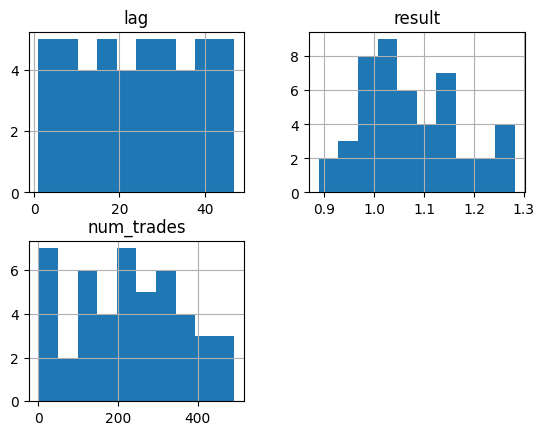

In [10]:
resultsDf.hist()
plt.show()

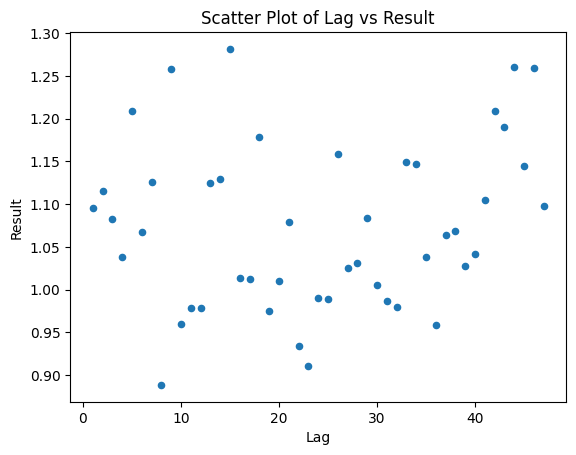

In [12]:
resultsDf.plot(kind='scatter', x='lag', y='result')
plt.title('Scatter Plot of Lag vs Result')
plt.xlabel('Lag')
plt.ylabel('Result')
plt.show()

In [14]:
resultsDf['result'].corr(resultsDf['lag'])

0.1591737996631865

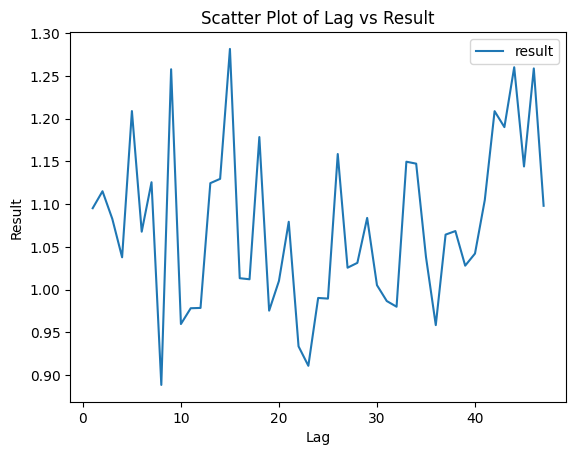

In [13]:
resultsDf.plot(kind='line', x='lag', y='result')
plt.title('Scatter Plot of Lag vs Result')
plt.xlabel('Lag')
plt.ylabel('Result')
plt.show()